# Objectives
YWBAT
* explain how bayesian classification works
* define a prior probability
* use sklearn gridsearchcv
* try and use a pipeline

# Questions
* when modeling
    * should we process validation set with data then split? 
    * I (Rafa) think that splitting first is better

In [125]:
import warnings
warnings.filterwarnings('ignore')

import numpy as np
import pandas as pd

from sklearn.naive_bayes import BernoulliNB, CategoricalNB, GaussianNB, MultinomialNB
from sklearn.model_selection import GridSearchCV, train_test_split
from sklearn.metrics import classification_report, confusion_matrix, plot_confusion_matrix
from sklearn.base import BaseEstimator

from sklearn.pipeline import Pipeline

import matplotlib.pyplot as plt
import seaborn as sns

import plotly.express as px
import plotly
import plotly.graph_objects as go

np.random.seed(42)

In [14]:
yes_no_converter = lambda x: 1 if x=="yes" else 0

In [51]:
df = pd.read_csv("../data/bank-full.csv")
df.head()

,age,job,marital,education,default,balance,housing,loan,contact,day,month,duration,campaign,pdays,previous,poutcome,y
0,58,management,married,tertiary,no,2143,yes,no,unknown,5,may,261,1,-1,0,unknown,no
1,44,technician,single,secondary,no,29,yes,no,unknown,5,may,151,1,-1,0,unknown,no
2,33,entrepreneur,married,secondary,no,2,yes,yes,unknown,5,may,76,1,-1,0,unknown,no
3,47,blue-collar,married,unknown,no,1506,yes,no,unknown,5,may,92,1,-1,0,unknown,no
4,33,unknown,single,unknown,no,1,no,no,unknown,5,may,198,1,-1,0,unknown,no


In [56]:
df_train, df_valid = train_test_split(df, test_size=0.10)

In [57]:
df_train.head()

,age,job,marital,education,default,balance,housing,loan,contact,day,month,duration,campaign,pdays,previous,poutcome,y
32834,27,blue-collar,single,secondary,no,-116,yes,yes,cellular,17,apr,432,2,343,1,failure,no
14711,33,admin.,married,secondary,no,0,yes,no,cellular,15,jul,120,6,-1,0,unknown,no
10513,31,technician,divorced,secondary,no,-1185,yes,no,unknown,16,jun,81,5,-1,0,unknown,no
4124,38,services,single,tertiary,no,323,yes,no,unknown,19,may,138,1,-1,0,unknown,no
7064,34,technician,single,secondary,no,1386,yes,yes,unknown,28,may,185,6,-1,0,unknown,no


# Bayesian Classification
* it's build on the distributions of features between different classes


## pros
* few assumptions of the data
* no requirements for the data
* assumption that features are independent events
* works well with high dimensions (large feature set)
* lower O than knn
* not many hyper-parameters to tune
    * simple to tune

## cons
* independence assumption is hard to meet in real world data
* gaussian assumption may not be valid
    * that the features are all from a normal distribution across the classes

In [58]:
def transform_df(df):
    df['housing'] = df['housing'].apply(yes_no_converter)
    # df['y'] = df['y'].apply(yes_no_converter)
    return df


df_train = transform_df(df_train)
df_valid = transform_df(df_valid)

In [59]:
display(df_train.head())
display(df_valid.head())

,age,job,marital,education,default,balance,housing,loan,contact,day,month,duration,campaign,pdays,previous,poutcome,y
32834,27,blue-collar,single,secondary,no,-116,1,yes,cellular,17,apr,432,2,343,1,failure,no
14711,33,admin.,married,secondary,no,0,1,no,cellular,15,jul,120,6,-1,0,unknown,no
10513,31,technician,divorced,secondary,no,-1185,1,no,unknown,16,jun,81,5,-1,0,unknown,no
4124,38,services,single,tertiary,no,323,1,no,unknown,19,may,138,1,-1,0,unknown,no
7064,34,technician,single,secondary,no,1386,1,yes,unknown,28,may,185,6,-1,0,unknown,no


,age,job,marital,education,default,balance,housing,loan,contact,day,month,duration,campaign,pdays,previous,poutcome,y
9777,39,management,married,primary,no,1873,0,no,unknown,9,jun,161,2,-1,0,unknown,no
39006,32,technician,single,secondary,no,55,1,no,cellular,18,may,185,1,-1,0,unknown,no
17239,48,technician,married,secondary,no,759,1,no,cellular,28,jul,84,5,-1,0,unknown,no
34008,29,management,married,tertiary,no,125,0,no,cellular,30,apr,130,2,-1,0,unknown,no
5724,37,admin.,married,secondary,no,-255,1,no,unknown,26,may,96,2,-1,0,unknown,no


In [60]:
feature_set = ['age', 'balance', 'housing']

In [61]:
# let's just build a NB model

In [62]:
g_bayes = GaussianNB()

In [63]:
X = df_train[feature_set]
y = df_train['y']

In [64]:
g_bayes.fit(X, y)

GaussianNB(priors=None, var_smoothing=1e-09)

In [68]:
X_valid = df_valid[feature_set]
y_valid = df_valid['y']

In [69]:
g_bayes.score(X_valid, y_valid)

0.8726227333038479

In [70]:
y_valid_pred = g_bayes.predict(X_valid)

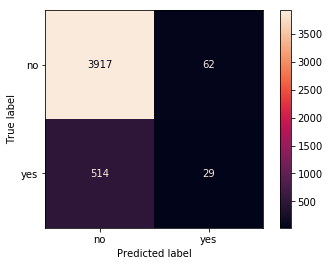

In [71]:
plot_confusion_matrix(g_bayes, X_valid, y_valid, cmap='rocket', values_format='0.4g')
plt.show()

# How do we fit this into a sklearn flow?

In [152]:
class SelectColumnsTransformer(BaseEstimator):
    def __init__(self, columns=None):
        self.columns = columns

    def transform(self, X, **transform_params):
        cpy_df = X[self.columns].copy()
        return cpy_df

    def fit(self, X, y=None, **fit_params):
        return self
    

class TransformCategorical():

    # here you define the operation it should perform
    def transform(self, X, y=None, **fit_params):
        try:
            X['housing'] = X['housing'].apply(self.yes_no_converter)
        except:
            pass
        return X

    # just return self
    def fit(self, X, y=None, **fit_params):
        return self
    
    @staticmethod
    def yes_no_converter(x):
        return 1 if x=="yes" else 0

In [153]:
# pipeline.fit() → fit then transform
# pipeline.predict () → transform then predicts on the model step
# pipeline assumes last step is a model that contains .predict(), .score(), .predict_proba()
pipeline = Pipeline(steps=[
    ("columnTransformer", SelectColumnsTransformer(columns=feature_set)),
    ("transformCategorical", TransformCategorical()),
    ("gaussianBayes", GaussianNB())
])

In [154]:
X_train = df_train.drop(columns=['y'])
y_train = df_train['y']
pipeline.fit(X_train, y_train)

Pipeline(memory=None,
         steps=[('columnTransformer',
                 SelectColumnsTransformer(columns=['age', 'balance',
                                                   'housing'])),
                ('transformCategorical',
                 <__main__.TransformCategorical object at 0x1a25ecca20>),
                ('gaussianBayes',
                 GaussianNB(priors=None, var_smoothing=1e-09))],
         verbose=False)

In [155]:
X_valid = df_valid.drop(columns=['y'])
y_valid = df_valid['y']
pipeline.score(X_valid, y_valid)

0.8724015922158337

# gridsearch, tho?

In [104]:
param_grid = {
    "gaussianBayes__var_smoothing": [1e-9, 1e-8, 1e-3, 1]
}

In [105]:
pipeline

Pipeline(memory=None,
         steps=[('columnTransformer',
                 <__main__.SelectColumnsTransformer object at 0x1a1debfc18>),
                ('transformCategorical',
                 <__main__.TransformCategorical object at 0x1a1debfe10>),
                ('gaussianBayes',
                 GaussianNB(priors=None, var_smoothing=1e-09))],
         verbose=False)

In [106]:
gs_pipeline = GridSearchCV(pipeline, param_grid=param_grid, verbose=2)

In [107]:
gs_pipeline.fit(X_train, y_train)

Fitting 5 folds for each of 4 candidates, totalling 20 fits
[CV] gaussianBayes__var_smoothing=1e-09 ..............................
[CV] ............... gaussianBayes__var_smoothing=1e-09, total=   0.1s
[CV] gaussianBayes__var_smoothing=1e-09 ..............................


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.1s remaining:    0.0s


[CV] ............... gaussianBayes__var_smoothing=1e-09, total=   0.1s
[CV] gaussianBayes__var_smoothing=1e-09 ..............................
[CV] ............... gaussianBayes__var_smoothing=1e-09, total=   0.1s
[CV] gaussianBayes__var_smoothing=1e-09 ..............................
[CV] ............... gaussianBayes__var_smoothing=1e-09, total=   0.1s
[CV] gaussianBayes__var_smoothing=1e-09 ..............................
[CV] ............... gaussianBayes__var_smoothing=1e-09, total=   0.1s
[CV] gaussianBayes__var_smoothing=1e-08 ..............................
[CV] ............... gaussianBayes__var_smoothing=1e-08, total=   0.1s
[CV] gaussianBayes__var_smoothing=1e-08 ..............................
[CV] ............... gaussianBayes__var_smoothing=1e-08, total=   0.1s
[CV] gaussianBayes__var_smoothing=1e-08 ..............................
[CV] ............... gaussianBayes__var_smoothing=1e-08, total=   0.1s
[CV] gaussianBayes__var_smoothing=1e-08 ..............................
[CV] .

[Parallel(n_jobs=1)]: Done  20 out of  20 | elapsed:    1.9s finished


GridSearchCV(cv=None, error_score=nan,
             estimator=Pipeline(memory=None,
                                steps=[('columnTransformer',
                                        <__main__.SelectColumnsTransformer object at 0x1a1debfc18>),
                                       ('transformCategorical',
                                        <__main__.TransformCategorical object at 0x1a1debfe10>),
                                       ('gaussianBayes',
                                        GaussianNB(priors=None,
                                                   var_smoothing=1e-09))],
                                verbose=False),
             iid='deprecated', n_jobs=None,
             param_grid={'gaussianBayes__var_smoothing': [1e-09, 1e-08, 0.001,
                                                          1]},
             pre_dispatch='2*n_jobs', refit=True, return_train_score=False,
             scoring=None, verbose=2)

In [109]:
best_model = gs_pipeline.best_estimator_

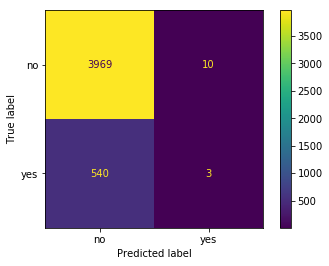

In [114]:
plot_confusion_matrix(best_model, X_valid, y_valid, values_format='0.4g')
plt.show()

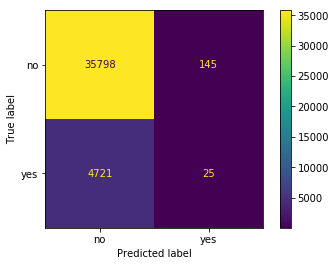

In [115]:
plot_confusion_matrix(best_model, X_train, y_train, values_format='0.5g')
plt.show()

# GRIDSEARCH, BUT EVEN COOLER!

In [118]:
pipeline

Pipeline(memory=None,
         steps=[('columnTransformer',
                 <__main__.SelectColumnsTransformer object at 0x1a1debfc18>),
                ('transformCategorical',
                 <__main__.TransformCategorical object at 0x1a1debfe10>),
                ('gaussianBayes',
                 GaussianNB(priors=None, var_smoothing=1e-09))],
         verbose=False)

In [117]:
df.head(2)

,age,job,marital,education,default,balance,housing,loan,contact,day,month,duration,campaign,pdays,previous,poutcome,y
0,58,management,married,tertiary,no,2143,yes,no,unknown,5,may,261,1,-1,0,unknown,no
1,44,technician,single,secondary,no,29,yes,no,unknown,5,may,151,1,-1,0,unknown,no


In [156]:
param_grid = {
    "columnTransformer__columns": [
            ['age', 'balance', 'housing'],
            ['age', 'balance', 'duration'],
            ['age', 'balance', 'housing', 'duration'],
        ],
    "gaussianBayes__var_smoothing": [1e-9, 1e-8, 1e-3, 1]
}

In [157]:
gs_pipeline = GridSearchCV(estimator=pipeline, param_grid=param_grid, cv=8, verbose=2, n_jobs=-1)

In [158]:
gs_pipeline.fit(X_train, y_train)

Fitting 8 folds for each of 12 candidates, totalling 96 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  25 tasks      | elapsed:    3.8s
[Parallel(n_jobs=-1)]: Done  96 out of  96 | elapsed:    7.0s finished


GridSearchCV(cv=8, error_score=nan,
             estimator=Pipeline(memory=None,
                                steps=[('columnTransformer',
                                        SelectColumnsTransformer(columns=['age',
                                                                          'balance',
                                                                          'housing'])),
                                       ('transformCategorical',
                                        <__main__.TransformCategorical object at 0x1a25ecca20>),
                                       ('gaussianBayes',
                                        GaussianNB(priors=None,
                                                   var_smoothing=1e-09))],
                                verbose=False),
             iid='deprecated', n_jobs=-1,
             param_grid={'columnTransformer__columns': [['age', 'balance',
                                                         'housing'],
             

In [159]:
gs_pipeline.best_estimator_

Pipeline(memory=None,
         steps=[('columnTransformer',
                 SelectColumnsTransformer(columns=['age', 'balance',
                                                   'duration'])),
                ('transformCategorical',
                 <__main__.TransformCategorical object at 0x1a2241e8d0>),
                ('gaussianBayes',
                 GaussianNB(priors=None, var_smoothing=0.001))],
         verbose=False)

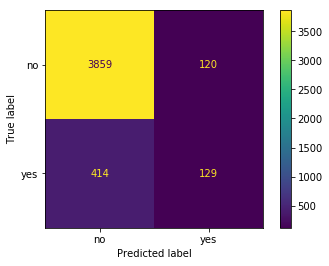

In [160]:
plot_confusion_matrix(gs_pipeline, X_valid, y_valid, values_format='0.5g')
plt.show()

In [135]:
gs_df = pd.DataFrame(gs_pipeline.cv_results_)
gs_df.head()

,mean_fit_time,std_fit_time,mean_score_time,std_score_time,param_columnTransformer__columns,param_gaussianBayes__var_smoothing,params,split0_test_score,split1_test_score,split2_test_score,split3_test_score,split4_test_score,split5_test_score,split6_test_score,split7_test_score,mean_test_score,std_test_score,rank_test_score
0,0.176543,0.014966,0.042354,0.011616,"[age, balance, housing]",1e-09,"{'columnTransformer__columns': ['age', 'balanc...",0.874779,0.872002,0.870035,0.874361,0.871412,0.873968,0.872198,0.874361,0.872889,0.001607,11
1,0.123523,0.015336,0.027581,0.003187,"[age, balance, housing]",1e-08,"{'columnTransformer__columns': ['age', 'balanc...",0.874779,0.872002,0.870035,0.874361,0.871412,0.873968,0.872198,0.874361,0.872889,0.001607,11
2,0.102033,0.007334,0.022869,0.004906,"[age, balance, housing]",0.001,"{'columnTransformer__columns': ['age', 'balanc...",0.874779,0.872395,0.873575,0.875344,0.872591,0.875541,0.871215,0.875737,0.873897,0.001590,10
3,0.103898,0.015880,0.022415,0.004903,"[age, balance, housing]",1,"{'columnTransformer__columns': ['age', 'balanc...",0.881266,0.879866,0.881636,0.881046,0.879670,0.881636,0.879866,0.880849,0.880729,0.000763,3
4,0.099738,0.013516,0.020877,0.003769,"[age, balance, duration]",1e-09,"{'columnTransformer__columns': ['age', 'balanc...",0.878710,0.880653,0.883995,0.878687,0.881046,0.884978,0.879670,0.874951,0.880336,0.002965,6


In [161]:
gs_df.sort_values('mean_test_score', ascending=False).head(5)

,mean_fit_time,std_fit_time,mean_score_time,std_score_time,param_columnTransformer__columns,param_gaussianBayes__var_smoothing,params,split0_test_score,split1_test_score,split2_test_score,split3_test_score,split4_test_score,split5_test_score,split6_test_score,split7_test_score,mean_test_score,std_test_score,rank_test_score
6,0.093101,0.011302,0.020604,0.003626,"[age, balance, duration]",0.001,"{'columnTransformer__columns': ['age', 'balanc...",0.879890,0.881046,0.884389,0.881439,0.88026,0.887338,0.881243,0.878883,0.881811,0.002572,1
10,0.109869,0.007711,0.023922,0.005168,"[age, balance, housing, duration]",0.001,"{'columnTransformer__columns': ['age', 'balanc...",0.879890,0.881046,0.884389,0.881439,0.88026,0.887338,0.881243,0.878883,0.881811,0.002572,1
3,0.103898,0.015880,0.022415,0.004903,"[age, balance, housing]",1,"{'columnTransformer__columns': ['age', 'balanc...",0.881266,0.879866,0.881636,0.881046,0.87967,0.881636,0.879866,0.880849,0.880729,0.000763,3
7,0.098369,0.011076,0.022380,0.004334,"[age, balance, duration]",1,"{'columnTransformer__columns': ['age', 'balanc...",0.881266,0.879866,0.881636,0.881046,0.87967,0.881636,0.879866,0.880849,0.880729,0.000763,3
11,0.111045,0.013489,0.022866,0.002481,"[age, balance, housing, duration]",1,"{'columnTransformer__columns': ['age', 'balanc...",0.881266,0.879866,0.881636,0.881046,0.87967,0.881636,0.879866,0.880849,0.880729,0.000763,3


# Even better Pipeline stuff!
* multiple model gridsearch in pipeline


## solutions 
* [https://stackoverflow.com/questions/23045318/scikit-grid-search-over-multiple-classifiers](https://stackoverflow.com/questions/23045318/scikit-grid-search-over-multiple-classifiers)

* [https://github.com/erdosn/dsc-pipelines-lab-v2-1-onl01-dtsc-ft-041320/blob/master/index.ipynb](https://github.com/erdosn/dsc-pipelines-lab-v2-1-onl01-dtsc-ft-041320/blob/master/index.ipynb)

## What did we learn? 
* pipeline options
* seeing how gridsearch can work
* gridsearchcv automatically does a train/test split
* what's the best way to save the output of a gridsearch?
* pros and cons of bayesian classification
* sklearn joblib
* what a non parametric model is

## What did you enjoy? 
* pipelines
* seeing gridsearch work

In [162]:
best_params = gs_df['params'][0]
best_params

{'columnTransformer__columns': ['age', 'balance', 'housing'],
 'gaussianBayes__var_smoothing': 1e-09}

In [163]:
from sklearn.externals import joblib

In [164]:
joblib.dump(gs_pipeline.best_estimator_, "best_model.pkl")

['best_model.pkl']